# Attribute Evaluation (Feature selection)

In machine learning, we can sometimes improve model performance by removing features that do not contain helpful information or by focusing only on the most important features. This can help to:

* Reduce overfitting. A smaller number of features mean models have less chance to overfit on noise present in the training data.
* Improve accuracy. Some models are not good at distinguishing between useful and useless features. By selecting only the most important features, we can sometimes improve performance of such models.
    
This task is often called feature selection and can be automated using different approaches.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

/Users/azagar/miniconda3/envs/is/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Example 1

In [2]:
imdb_dataset = load_dataset('imdb')
data = pd.DataFrame(imdb_dataset['train'].shuffle(seed=42).select(range(1000)))
data['label'] = data['label'].apply(lambda x: 'pos' if x else 'neg')
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()  # Use TF-IDF vectorizer for text to numerical feature conversion
X_train_vec = vectorizer.fit_transform(X_train).todense()
X_test_vec = vectorizer.transform(X_test).todense()

X_train_vec.shape

(800, 15735)

Our tf-idf vector contains a large amount of rows (features). Most features are not related to review scores and will not be useful when training a classification model. Can we determine which features are useful?

## Univariate Feature Selection

Sklearn contains functions that can evaluate whether certain features are useful for predicting a given class. Univariate feature selection methods do this using statistical tests.

Mutual information measures the mutual dependence between two variables. In other words, it tells us whether knowing something about variable X will reduce the uncertainty about variable Y. If X and Y are independent, MI is equal to 0. Higher values indicate some relation between X and Y. 

f score uses analysis of variance to discover feature importances. For a given feature, it compares the distributions across all possible class values. The more the distributions differ between classes, the better the score.

In [3]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif

In [4]:
# A list of words in our tf-idf matrix
list(vectorizer.vocabulary_)[:10]

['it',
 'good',
 'to',
 'see',
 'that',
 'vintage',
 'film',
 'buff',
 'have',
 'correctly']

In [5]:
# Evaluate each word with f values
feature_scores = f_classif(np.asarray(X_train_vec), y_train)[0]
feature_scores

array([1.53890401, 0.97527847, 0.97527847, ..., 0.97527847, 1.02534898,
       1.02534898])

In [6]:
word_scores = {k: v for k, v in zip(vectorizer.get_feature_names_out(), feature_scores)}
sorted_words = sorted(word_scores, key = word_scores.get)

# Print 30 words with highest mutual information
print("Highest")
for i in range(1, 31):
    print(sorted_words[-i], word_scores[sorted_words[-i]])
    
# And 30 lowest:
print("Lowest")
for i in range(0, 30):
    print(sorted_words[i], word_scores[sorted_words[i]])
    

Highest
bad 69.99222922406418
no 56.37679632890762
worst 47.63848575734972
great 41.02246042998715
waste 34.99329195124218
terrible 27.924068425714673
this 27.53882523292081
both 27.479838831082354
movie 27.06076907516349
boring 26.173496527653246
plot 26.11396062063015
why 24.947723309900066
do 23.879197916330742
wonderful 23.039593030650963
poor 22.026395812975608
script 20.6811289308182
or 19.10640468002289
something 18.496927481887628
awful 18.25197149709138
avoid 17.709542594014806
love 17.42787549116822
don 17.418206394269557
ridiculous 17.316282647940664
nothing 16.182924475298908
annoying 16.157519770169692
minutes 15.883723201606175
reason 15.749724430003575
beautiful 15.316361728146317
because 15.19011065370263
superb 14.630702677330062
Lowest
operation 2.480009952090623e-07
conscience 7.793153656385402e-07
sundance 1.163337465039585e-06
prove 2.245201601827665e-06
psychologist 2.4566163643658115e-06
uncle 2.7852019939331414e-06
realize 3.1452352849538705e-06
proportions 3.57

In [7]:
bad_features_train = X_train_vec[:,feature_scores < 1 ]
bad_features_test = X_test_vec[:,feature_scores < 1]
bad_features_train.shape

(800, 7653)

In [8]:
good_features_train = X_train_vec[:,feature_scores > 1 ]
good_features_test = X_test_vec[:,feature_scores > 1]
good_features_train.shape

(800, 8082)

In [9]:
from sklearn.neighbors import KNeighborsClassifier

# KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(np.asarray(bad_features_train), y_train)
knn_predictions = knn_model.predict(np.asarray(bad_features_test))
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy on bad features:", knn_accuracy)

# KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(np.asarray(good_features_train), y_train)
knn_predictions = knn_model.predict(np.asarray(good_features_test))
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN on good features:", knn_accuracy)


KNN Accuracy on bad features: 0.465
KNN on good features: 0.535


Good features perform better than bad features, but are they better than all features?

In [10]:
# KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(np.asarray(X_train_vec), y_train)
knn_predictions = knn_model.predict(np.asarray(X_test_vec))
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy on all features:", knn_accuracy)

KNN Accuracy on all features: 0.625


Lets evaluate different feature subsets

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [12]:
for n_feats in range(100, X_train_vec.shape[1], 1000):
    feature_selector = SelectKBest(f_classif, k=n_feats)
    X_train_n_best = feature_selector.fit_transform(np.asarray(X_train_vec), y_train)
    X_test_n_best = feature_selector.transform(np.asarray(X_test_vec))
    
    knn_model = KNeighborsClassifier()
    knn_model.fit(X_train_n_best, y_train)
    knn_predictions = knn_model.predict(X_test_n_best)
    knn_accuracy = accuracy_score(y_test, knn_predictions)
    print(n_feats, knn_accuracy)

100 0.67
1100 0.655
2100 0.63
3100 0.595
4100 0.56
5100 0.575
6100 0.54
7100 0.54
8100 0.535
9100 0.535
10100 0.555
11100 0.59
12100 0.545
13100 0.595
14100 0.61
15100 0.595


Certain subsets of features improve performance over all features! This depends on the data and type of model, but feature selection can sometimes be an important part of classification.

# Example 2 - Dependent Features

The previous features assume the features are indepentend. In real-world scenarions, this is not always true and can make such methods innefective. For example, consider the following artificial example:

In [13]:
quadrant = pd.read_csv("quadrant.txt")
quadrant

a1  a2  a3  a4  a5  a6  a7  a8  Class
0   -74  98  25  30 -11  34  67  35   True
1   -42 -87  24  88  71  74  87 -74  False
2   -44  72  23 -67  20  33  75 -60   True
3   -75 -88 -59  29 -92 -27 -61 -43  False
4   -41  69  -9   7 -24 -10  -6  -7   True
..   ..  ..  ..  ..  ..  ..  ..  ..    ...
995  88 -55 -47 -90  98 -35  34 -79   True
996  37 -77  52 -31  61 -37  24 -55   True
997 -92 -66 -65   8 -64  73 -15 -81  False
998   6  46 -16  50 -36  65 -53  96  False
999 -75  73  36  78 -19 -49 -42  34   True

[1000 rows x 9 columns]

"Quadrant" is a dummy dataset where:

* Every feature is, by itself, independent from the class variable. We cannot predict the class based on 1 feature alone
* The only way to make correct predictions is by looking at both a1 and a2.

In [14]:
import matplotlib.pyplot as plt

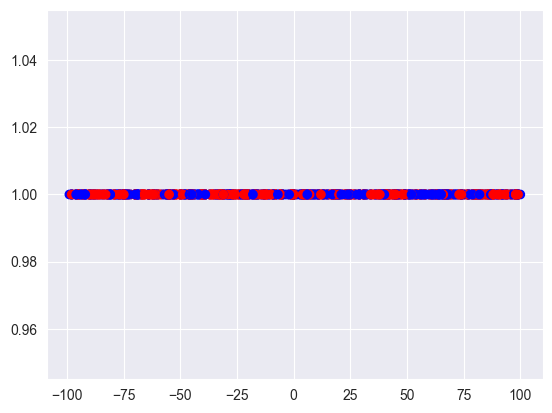

In [15]:
colors = ['red' if x else 'blue' for x in quadrant['Class']]
plt.scatter(quadrant['a1'],[1 for _ in quadrant['a1']], color=colors)

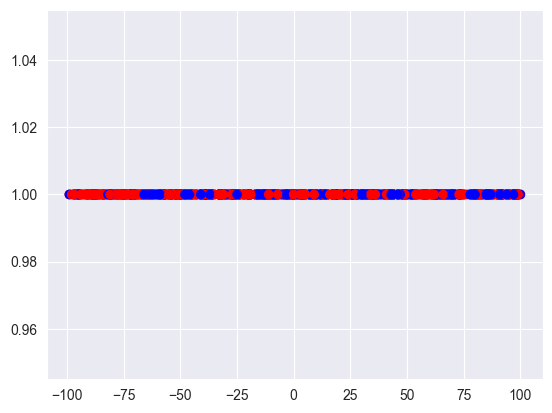

In [16]:
plt.scatter(quadrant['a2'],[1 for _ in quadrant['a1']], color=colors)

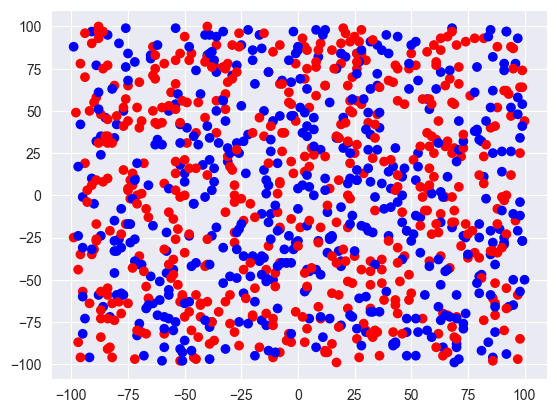

In [17]:
colors = ['red' if x else 'blue' for x in quadrant['Class']]
plt.scatter(quadrant['a2'], quadrant ['a3'], color=colors)

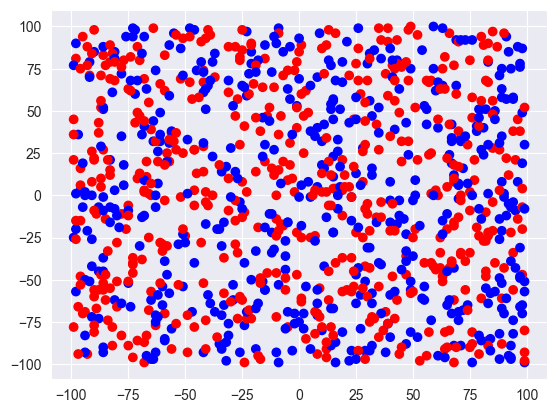

In [18]:
plt.scatter(quadrant['a4'], quadrant ['a5'], color=colors)

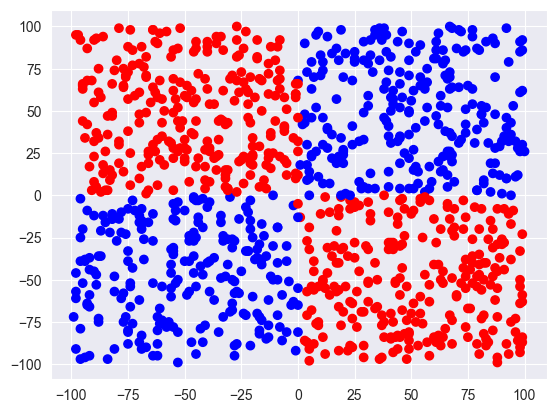

In [19]:
plt.scatter(quadrant['a1'], quadrant ['a2'], color=colors)

Measures that assume features are independent will fail to properly evaluate features

In [20]:
mutual_info_classif(quadrant.drop('Class', axis=1), quadrant['Class'])

array([0.00067506, 0.        , 0.        , 0.01132021, 0.04009068,
       0.02161443, 0.00266215, 0.00634246])

In [21]:
f_classif(quadrant.drop('Class', axis=1), quadrant['Class'])[0]

array([0.08224689, 1.5022783 , 1.65611467, 4.75349276, 0.80372455,
       0.00653336, 1.92820717, 0.11729072])

Models using the selected measures cannot classify examples (unless the feature selection methods get lucky and guess the correct features)

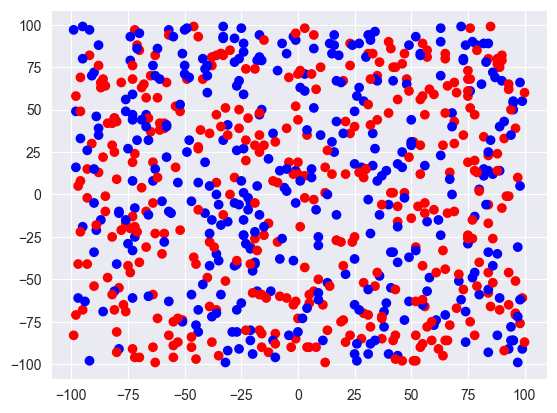

In [22]:
from sklearn.tree import DecisionTreeClassifier

train_x, test_x, train_y, test_y = train_test_split(quadrant.drop('Class', axis=1), quadrant['Class'])

feature_selector = SelectKBest(mutual_info_classif, k=2)
quadrant_2_feats_train = feature_selector.fit_transform(train_x, train_y)
colors = ['red' if x else 'blue' for x in train_y]
plt.scatter([x[0] for x in quadrant_2_feats_train], [x[1] for x in quadrant_2_feats_train], color=colors )

In [23]:
quadrant_2_feats_test = feature_selector.transform(test_x)
dt_model = DecisionTreeClassifier()
dt_model.fit(quadrant_2_feats_train, train_y)
dt_predictions = dt_model.predict(quadrant_2_feats_test)
dt_accuracy = accuracy_score(test_y, dt_predictions)
dt_accuracy

0.524

Instead, we can use methods that take feature dependency into account

In [24]:
#!pip install sklearn_relief

In [25]:
import sklearn_relief as relief

In [26]:
r = relief.Relief(n_features=2, n_jobs=1)

In [27]:
r.fit(np.asarray(train_x), np.asarray(train_y))
relief_2_feats_train = r.transform(np.asarray(train_x))
relief_2_feats_test = r.transform(np.asarray(test_x))

In [28]:
print("Relief feature weights")
print(r.w_)

Relief feature weights
[41.59 40.89 20.8  23.17 22.83 24.72 22.25 24.81]


The first two features are correctly identified as important! Relief takes into account feature dependencies and correctly identifies the first two as most useful.

In [29]:
dt_model = DecisionTreeClassifier()
dt_model.fit(relief_2_feats_train, train_y)
dt_predictions = dt_model.predict(relief_2_feats_test)
dt_accuracy = accuracy_score(test_y, dt_predictions)
dt_accuracy

0.992

# Example 3 - Model-based feature selection

Some models already evaluate features during training. For example, decision trees and random forests can assign importances to features that are used to split the trees. After training, we can obtain these features and use them in other models or use them to explain how a model obtained its predictions.

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
X_train_vec

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
logistic_model = RandomForestClassifier()
logistic_model.fit(np.asarray(X_train_vec), y_train)

for score, name in list(sorted(zip(logistic_model.feature_importances_, vectorizer.get_feature_names_out()), reverse=True))[:10]:
    print(name, score)

bad 0.011280921029698888
worst 0.008156406338111169
movie 0.0074821396186236025
no 0.007029685934800498
and 0.0057225935509488575
script 0.005127689003411775
great 0.005106834271914218
waste 0.005083353475039723
really 0.005062169153407971
not 0.0048674834423996375


# Example 4 - Recursive feature elimination

Recursive feature elimination (RFE) tries to select a subset of best features by recursively removing unhelpful features. It trains a model multiple times, removing a certain amount least-helpful features (according to model-based feature importance) after each iteration.

In [33]:
 from sklearn.feature_selection import RFE

In [34]:
estimator = RandomForestClassifier()

In [35]:
selector = RFE(estimator, n_features_to_select = 12000, step=500, verbose=1)
selector = selector.fit(np.asarray(X_train_vec), y_train)

Fitting estimator with 15735 features.
Fitting estimator with 15235 features.
Fitting estimator with 14735 features.
Fitting estimator with 14235 features.
Fitting estimator with 13735 features.
Fitting estimator with 13235 features.
Fitting estimator with 12735 features.
Fitting estimator with 12235 features.


In [36]:
X_train_rfe = selector.transform(np.asarray(X_train_vec))
X_test_rfe = selector.transform(np.asarray(X_test_vec))

estimator = RandomForestClassifier()
estimator.fit(np.asarray(X_train_vec), y_train)
preds = estimator.predict(np.asarray(X_test_vec))
score_vec = accuracy_score(y_test, preds)
print("Random forest score on all features:", score_vec)


estimator = RandomForestClassifier()
estimator.fit(X_train_rfe, y_train)
preds = estimator.predict(X_test_rfe)
score_rfe = accuracy_score(y_test, preds)
print("Random forest score on RFE features:", score_rfe)

Random forest score on all features: 0.76
Random forest score on RFE features: 0.78
